# Gaussian Filter for [OII] Doublet Detection

### Author: Tanveer Karim
### Last Updated: 23 April 2018

This is a toy problem to create a Gaussian filter to detect [OII] doublets $(\lambda 3727-3729$ $\mathring{A})$ for the Dark Energy Spectroscopic Instrument (DESI) Emission-Line-Galaxy (ELG) target selection. The goal is to pass the Gaussian filter over 1-D spectra obtained from the MMT and detect the existence of (if any) O II doublets.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [5]:
def Model(params, Amp = 1, std = 0.75): #Default, A = 1, std = 0.75
    """Returns the [OII] doublet model
    Parameters: Amp Amplitude
                params: tuple of spectra and lambda0 (centre point of the Model)
    """
    
    spectra, lambda0 = params
    Gaussian = lambda x, mean, std: np.exp(-((x[:, np.newaxis] - mean)/std)**2)
    
    #Values from http://classic.sdss.org/dr6/algorithms/linestable.html
    separation = (3729.875-3727.092)/2 #separation between lambda0 and the emission lines
    
    return Amp*(Gaussian(spectra, lambda0-separation, std) + Gaussian(spectra, lambda0+separation, std))

Assume that x values are in $\mathring{A}$. Thus, the two Gaussians are centred at 3727 and 3729 respectively. We pick the width of the Gaussians to be $3/4 \mathring{A}$ a priori because $1.5 \mathring{A}$ might result in the Gaussians being too close to each other.

### SNR calculator

This script will go through the synthetic data and determine SNR at each $\lambda_{0}$ to determine emission lines.

In [6]:
def SNR_Calculator(wavelength, flux, err):
    """Returns the SNR and lambda0 such that SNR is a function of lambda0
    Parameters: wavelength: array of wavelength range over which to test the filter
                flux: array of flux corresponding to the wavelength range
                err: array of flux error
                
    Returns: SNR: Signal-to-noise ratios of Amplitude
             lambda0: Different central values of the filter
    """
    
    lambda0_emitted = 3727.092 + (3729.875-3727.092)/2 #Midpoint of OII doublet
        
    #Initialise numpy arrays
    width = np.arange(0.1, 2.1, .1) #To calculate SNR at different linewidth
    z = np.zeros(len(wavelength))
    SNR = np.zeros((len(width), len(wavelength))) #width vs z grid
    dataPrime = flux/err #signal of data
    
    #Calculate SNR at different lambda0 and w
    for i in range(len(wavelength)):
        for j in range(len(width)):
            lambda0 = wavelength[i]
            modelFlux = Model((wavelength, lambda0), 1, width[j])
            modelPrime = modelFlux/err
            
            """A = (fluxPrime (dot) modelPrime)/(modelPrime (dot) modelPrime)
            sigmaA = 1/sqrt(modelPrime (dot) modelPrime)
            SNR = A/sigmaA"""
            sigmaA = 1./np.sqrt(np.dot(modelPrime, modelPrime))
            A = np.dot(dataPrime, modelPrime)/(sigmaA**(-2))
            SNR[j][i] = A/sigmaA
            
        #Convert lambda0 to z
        z[i] = lambda0/lambda0_emitted - 1
    
    return SNR, z, width

### Synthetic spectra

Now we generate synthetic spectra and test the model on it

Text(0,0.5,'Flux Error')

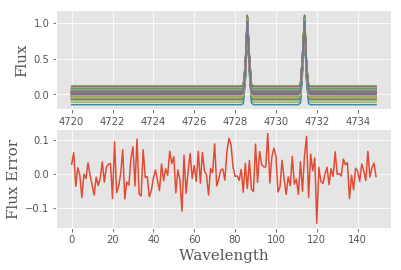

In [7]:
synthSpectra = np.arange(4720, 4735, .1) #Note that spacing must be geq the minimum linewidth, i.e. 0.1
pureData = Model((synthSpectra, 4730), 1, .1)
errstd = 0.05
errData = np.random.normal(0, errstd, synthSpectra.shape)
synthData = pureData + errData

plt.subplot(2,1,1)
plt.plot(synthSpectra, synthData)
plt.plot(synthSpectra, pureData)
plt.xlabel("Wavelength", fontname = 'serif', fontsize = 15)
plt.ylabel("Flux", fontname = 'serif', fontsize = 15)

plt.subplot(2,1,2)
plt.plot(errData)
plt.xlabel("Wavelength", fontname = 'serif', fontsize = 15)
plt.ylabel("Flux Error", fontname = 'serif', fontsize = 15)

[Text(33,0.5,'Line width w'), Text(0.5,15,'Redshift z')]

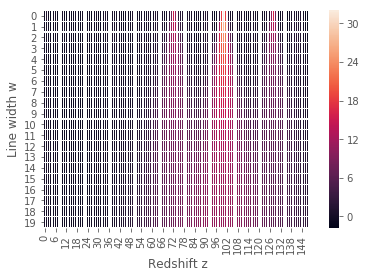

In [6]:
SNR, z, w = SNR_Calculator(synthSpectra, synthData, errstd)
ax = sns.heatmap(SNR, linewidth=0.1)#, xticklabels=z, yticklabels=w)
ax.set(xlabel='Redshift z', ylabel='Line width w')

Text(0,0.5,'SNR')

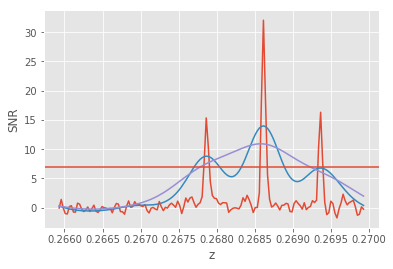

In [7]:
plt.plot(z, SNR[0])
plt.plot(z, SNR[10])
plt.plot(z, SNR[19])
plt.axhline(7)
plt.xlabel("z")
plt.ylabel("SNR")

### Synthetic Spectra 2

Here, we will inject a simple Gaussian signal and a double Gaussian signature and test the SNR_calculator function

Text(0,0.5,'Flux Error')

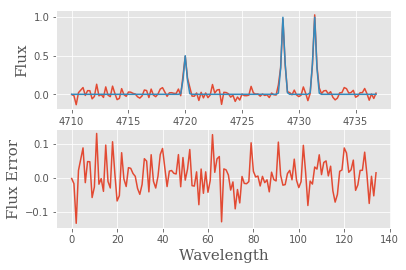

In [8]:
Gaussian = lambda x, mean, std: np.exp(-((x - mean)/std)**2)

synthSpectra = np.arange(4710, 4737, .2)
pureData = Model((synthSpectra, 4730), 1, .2) + 0.5*Gaussian(synthSpectra, 4720, .2)
errstd = 0.05
errData = np.random.normal(0, errstd, synthSpectra.shape)
synthData = pureData + errData

plt.subplot(2,1,1)
plt.plot(synthSpectra, synthData)
plt.plot(synthSpectra, pureData)
plt.xlabel("Wavelength", fontname = 'serif', fontsize = 15)
plt.ylabel("Flux", fontname = 'serif', fontsize = 15)

plt.subplot(2,1,2)
plt.plot(errData)
plt.xlabel("Wavelength", fontname = 'serif', fontsize = 15)
plt.ylabel("Flux Error", fontname = 'serif', fontsize = 15)

[Text(33,0.5,'Line width w'), Text(0.5,15,'Redshift z')]

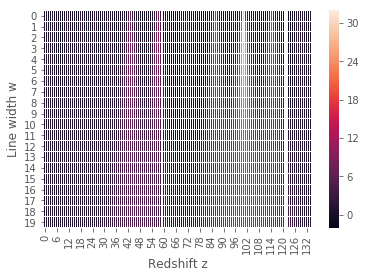

In [9]:
SNR, z, w = SNR_Calculator(synthSpectra, synthData, errstd)
ax = sns.heatmap(SNR, linewidth=0.01)#, xticklabels=z, yticklabels=w)
ax.set(xlabel='Redshift z', ylabel='Line width w')

Text(0,0.5,'SNR')

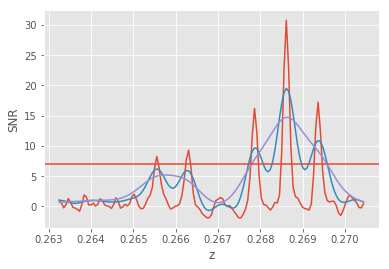

In [10]:
plt.plot(z, SNR[2])
plt.plot(z, SNR[10])
plt.plot(z, SNR[19])
plt.axhline(7)
plt.xlabel("z")
plt.ylabel("SNR")

### Synthetic Spectra 3

Here, we will generate the OII doublet with different amplitudes

In [ ]:
def Model_diff_Amp(params, Amp = 1, std = 0.75, key = 'R'): #Default, A = 1, std = 0.75
    """Returns the [OII] doublet model
    Parameters: Amp Amplitude
                params: tuple of spectra and lambda0 (centre point of the Model)
    """
    
    spectra, lambda0 = params
    Gaussian = lambda x, mean, std: np.exp(-((x - mean)/std)**2)
    
    #Values from http://classic.sdss.org/dr6/algorithms/linestable.html
    separation = (3729.875-3727.092)/2 #separation between lambda0 and the emission lines
    
    #key selects which doublet to reduce in amplitude
    if(key == 'R'):
        return Amp*(Gaussian(spectra, lambda0-separation, std)) + ((0.5*Amp)*Gaussian(spectra, lambda0+separation, std))
    elif(key == 'L'):
        return (0.25*Amp)*(Gaussian(spectra, lambda0-separation, std)) + Amp*Gaussian(spectra, lambda0+separation, std)

In [ ]:
synthSpectra = np.arange(4720, 4735, .1) #Note that spacing must be geq the minimum linewidth, i.e. 0.1
pureData = Model_diff_Amp((synthSpectra, 4730), std=.1)
errstd = 0.05
errData = np.random.normal(0, errstd, synthSpectra.shape)
synthData = pureData + errData

plt.subplot(2,1,1)
plt.plot(synthSpectra, synthData)
plt.plot(synthSpectra, pureData)
plt.xlabel("Wavelength", fontname = 'serif', fontsize = 15)
plt.ylabel("Flux", fontname = 'serif', fontsize = 15)

plt.subplot(2,1,2)
plt.plot(errData)
plt.xlabel("Wavelength", fontname = 'serif', fontsize = 15)
plt.ylabel("Flux Error", fontname = 'serif', fontsize = 15)

In [ ]:
SNR, z, w = SNR_Calculator(synthSpectra, synthData, errstd)
ax = sns.heatmap(SNR, linewidth=0.01)#, xticklabels=z, yticklabels=w)
ax.set(xlabel='Redshift z', ylabel='Line width w')

Text(0,0.5,'SNR')

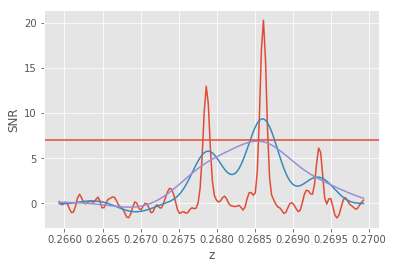

In [14]:
plt.plot(z, SNR[1])
plt.plot(z, SNR[10])
plt.plot(z, SNR[19])
plt.axhline(7)
plt.xlabel("z")
plt.ylabel("SNR")

Text(0,0.5,'Flux Error')

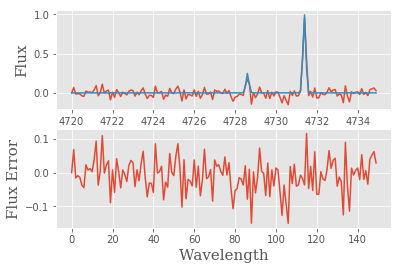

In [15]:
synthSpectra = np.arange(4720, 4735, .1) #Note that spacing must be geq the minimum linewidth, i.e. 0.1
pureData = Model_diff_Amp((synthSpectra, 4730), std=.1, key='L')
errstd = 0.05
errData = np.random.normal(0, errstd, synthSpectra.shape)
synthData = pureData + errData

plt.subplot(2,1,1)
plt.plot(synthSpectra, synthData)
plt.plot(synthSpectra, pureData)
plt.xlabel("Wavelength", fontname = 'serif', fontsize = 15)
plt.ylabel("Flux", fontname = 'serif', fontsize = 15)

plt.subplot(2,1,2)
plt.plot(errData)
plt.xlabel("Wavelength", fontname = 'serif', fontsize = 15)
plt.ylabel("Flux Error", fontname = 'serif', fontsize = 15)

[Text(33,0.5,'Line width w'), Text(0.5,15,'Redshift z')]

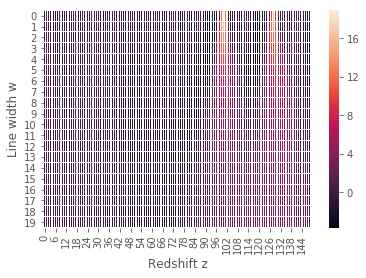

In [16]:
SNR, z, w = SNR_Calculator(synthSpectra, synthData, errstd)
ax = sns.heatmap(SNR, linewidth=0.01)#, xticklabels=z, yticklabels=w)
ax.set(xlabel='Redshift z', ylabel='Line width w')

Text(0,0.5,'SNR')

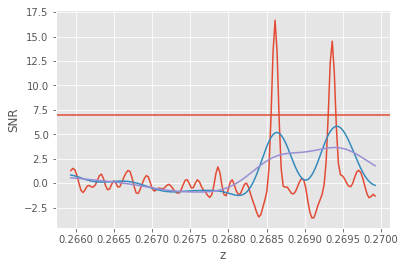

In [17]:
plt.plot(z, SNR[1])
plt.plot(z, SNR[10])
plt.plot(z, SNR[19])
plt.axhline(7)
plt.xlabel("z")
plt.ylabel("SNR")

### BinoSpec data

In [2]:
from utils import bino_data_preprocess

In [3]:
data, header = bino_data_preprocess("../../data/v1/st82-1hr-600/obj_abs_slits_lin.fits", 
                                    "../../data/v1/st82-1hr-600/obj_abs_err_slits_lin.fits")

In [4]:
header[1]

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -64 / Number of bits per data pixel                  
NAXIS   =                    2 / Number of data axes                            
NAXIS1  =                 5632 /                                                
NAXIS2  =                   31 /                                                
PCOUNT  =                    0 / No Group Parameters                            
GCOUNT  =                    1 / One Data Group                                 
EXTNAME = 'TARGET 01'          /                                                
YOFFSET =                  255 /                                                
AIRMASS =              1.16410 /                                                
SIDE    = 'A       '           /                                                
SLITID  =                   16 / slit id                                        
SLITRA  =        11.65745168

In [6]:
idx = 48
image = data[idx][:, :, 0]
err = data[idx][:, :, 1]
ivar = 1/err**2

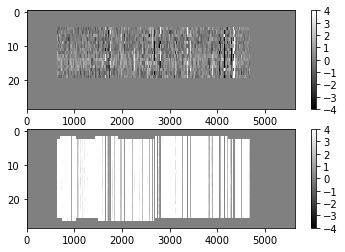

In [13]:
plt.subplot(2, 1, 1)
plt.imshow(image, aspect = 'auto',  vmin=-4, vmax=4, cmap = 'gray', interpolation = 'None')
plt.colorbar()
#plt.xlim([3720, 4200])
#plt.xlim([2900, 3100]) #To find the central region of the brightest blob

plt.subplot(2, 1, 2)
plt.imshow(ivar,  vmin=-4, vmax=4, aspect = 'auto', cmap = 'gray', interpolation = 'None')
plt.colorbar()
#plt.xlim([3720, 4200])
#plt.xlim([2900, 3100]) #To find the central region of the brightest blob

In [7]:
Nobjs = 64

i = 1
crval1_600 = float(str(header).split("CRVAL1")[1].split("=")[1].split("/")[0])
cdelt1_600 = float(str(header).split("CRVAL1")[1].split("=")[2].split("/")[0])

for i in np.arange(2, Nobjs):
    tmp1 = float(str(header).split("CRVAL1")[1].split("=")[1].split("/")[0])
    tmp2 = float(str(header).split("CRVAL1")[1].split("=")[2].split("/")[0])    
    if np.abs(tmp1-crval1_600)>1e-6:
        print(tmp1)
    if np.abs(tmp2-cdelt1_600)>1e-6:
        print(tmp2)
        
wave_grid_600 = crval1_600 + cdelt1_600 * np.arange(image[1].shape[0])
wave_grid_600 *= 10

### Profile

In [9]:
idx = 63 # 48
image = data[idx][:, :, 0]
err = data[idx][:, :, 1]

image[:5] = 0
image[20:] = 0

ivar = 1/err**2

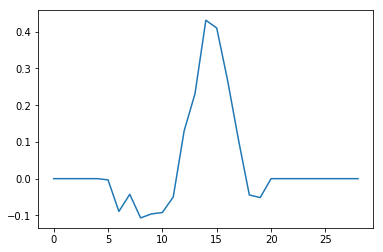

In [10]:
profile = np.sum(image * ivar, axis=-1) / np.sum(ivar, axis=-1)
profile/= np.sum(profile)
plt.figure()
plt.plot(profile)

### Spectrum

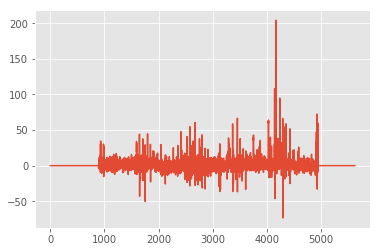

In [35]:
spectrumRaw = image.sum(axis=0)
plt.figure()
plt.plot(spectrumRaw)

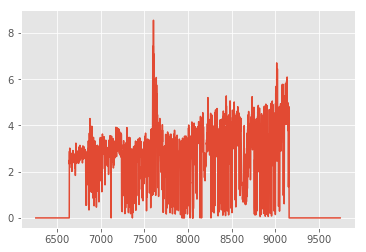

In [81]:
#np.sum(np.multiply(profile.T, ivar), axis = 0).shape
ivarClean2 = np.dot((profile**2).T, ivar)
errClean2 = 1/np.sqrt(ivarClean2)

plt.plot(wave_grid_600, ivarClean2)

In [82]:
spectrumClean = np.sum(np.multiply(image.T, np.multiply(ivar.T, profile)).T, axis = 0)/ivarClean2
spectrumClean = np.dot(profile.T, (image * ivar)) / ivarClean2

ivarClean = np.sum(np.multiply(ivar.T, profile).T, axis = 0)
errClean = 1/np.sqrt(ivarClean)

C:\Users\Tanveer\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in sqrt


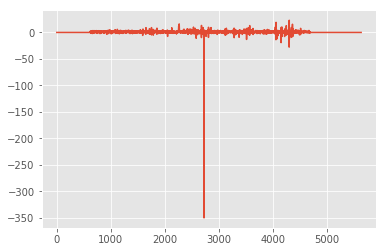

In [85]:
plt.plot(spectrumClean)
plt.show()
plt.close()

(-0.1, 0.1)

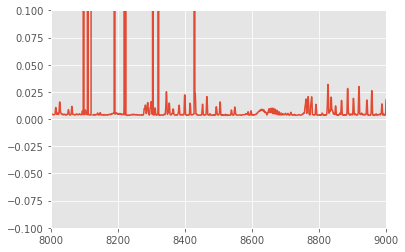

In [23]:
#plt.plot(wave_grid_600, spectrumClean)
#plt.plot(wave_grid_600, ivarClean)
plt.plot(wave_grid_600, errClean)
plt.xlim([8000, 9000]); plt.ylim([-.1, .1])

In [55]:
SNR, z, w = SNR_Calculator(wave_grid_600, spectrumClean, errClean2)

[Text(33,0.5,'Line width w'), Text(0.5,15,'Redshift z')]

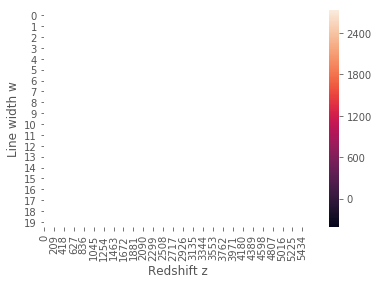

In [28]:
ax = sns.heatmap(SNR, linewidth=0.01)#, xticklabels=z, yticklabels=w)
ax.set(xlabel='Redshift z', ylabel='Line width w')

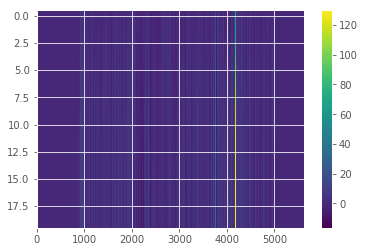

In [45]:
plt.imshow(SNR, aspect='auto')
plt.colorbar()

In [46]:
np.where(SNR == SNR.max())[0][0]

19

In [47]:
SNR[18][4172]

123.77526117024622

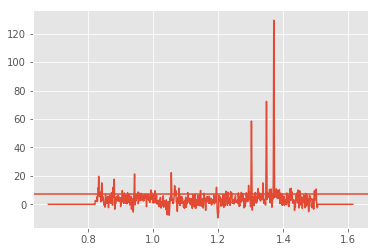

In [48]:
plt.plot(z, SNR[18])
plt.axhline(7)

In [31]:
SNR

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])